In [11]:
%matplotlib inline  
#%matplotlib notebook
#%pylab
from __future__ import division
import numpy as np
import sys
import re
import os
import fileinput
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
import scipy.special as scs
from scipy.stats import norm
import operator
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.colorbar as cobar

# Change font sizes to makes figure legends and axes labels bigger
# NOTE: 10 pt is the default standard font size
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16)    # legend fontsize

# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data

oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    # GENERAL PYTHON DATA READ FUNCTION!!!
    missed_line_inds = []
    temp_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(10,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        match_hash = re.search('#',line)
        if match_ast or match_inf or match_hash or (line.strip()==''):
            missed_line_inds.append(check)
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column ',col_numb,' values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs

   
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict


# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Standard deviations:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        # use if statement to avoid repeating terms in symmetrical covariance matrix
        # should result in increasing number of entries for increasing row number
        y = abs(covar_matrix[i]/func_coeffs[i])
        f.write(str(y) + '\t')
        yterm_count += 1
        sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# linear function
def linear_func(xdata,a,b):
    y = (a*xdata) + b
    return y

# quadratic function
def quad_func(xdata,a,b,c):
    y = a*(xdata**2) + (b*xdata) + c
    return y

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*((1.0e-04*xdata)**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = a*(np.exp(b*(1.0e-04*xdata))) + c
    return y

# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# Teff & logg quadratic-like function
# Need y = 0 at Teff cut-off value -> put (Tcut-Tdata) at front
def Teff_logg_product_func(Tdata,Tcut,gdata,ind,a,b,c): #,d
    y = ((Tcut-Tdata)**ind)*(a*(5.0-gdata)**b) + c #*(5.0-gdata)**(b-1)) + d
    return y

#polyfit_coeffs,polyfit_cov = (Tdata-Tcut),Aratio_data,deg

# try to get compensatory functions
# To avoid non-convergence
def Teff_logg_polynomial(Tdata,Tcut,gdata,a,b,c=0.0,d=2):
    # note: want b (power) to be integer!
    y = ((a*(Tcut-Tdata)**d + b*(Tcut-Tdata)**(d-1))*(5.0-gdata)) + c
    return y

# Teff, metallicity & logg quadratic-like function
def Teff_logg_metal_product_func(Tdata,gdata,metal_val,a,b,c=0.0,d=2):
    # assuming Zsolar = 0.0172
    y = ((a*(Tcut-Tdata)**d + b*(Tcut-Tdata)**(d-1))*(5.0-gdata)) + c
    #y = a*(Tdata*gdata) + b*(gdata**2) + c + d*((0.0172 - metal_val)*Tdata)
    return y

# Full addition of exponential function to power-law
def full_pow_plus_exp_func(xdata,a,b,c,d,e):
    y = (d*(xdata**e)) + (a*(np.exp(b*xdata))) + c
    return y

"""
maybe use underdamped oscillation as solution? With log(g), Z related to the value of the damping ratio, G?
For underdamped systems, 0 < G < 1
Approach: change in Ax/Av, call x, has solution x = C*exp(st)
where s = -w_n * (G +/- i*sqrt(1 - G^2))
NumPy: 'j' is the character used for imaginary numbers
"""
# PROBLEM: if zeta2**2 > 1, gives nan rather than evaluating two imaginary numbers!
# Note: General solution is linear sum of terms!
def decay_coeff_nan_avoid(omega,zeta,RIF=1.0):
    if (abs(zeta) <= 1.0):
        s1 = -omega*( zeta + RIF*1.0j*np.sqrt(1-zeta**2) ) #r*
        s2 = -omega*( zeta - RIF*1.0j*np.sqrt(1-zeta**2) )
    else:
        s1 = -omega*( zeta - RIF*np.sqrt((zeta**2) - 1) ) #r* #r*
        s2 = -omega*( zeta + RIF*np.sqrt((zeta**2) - 1) )
    return s1,s2


# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects


# need to combine some effects of Teff, log(g)
# use Teff-keyed dictionaries as the dataset
def from_keys_get_numerical_data(input_dict):
    key_vals_list = []
    for key in sorted(input_dict.iterkeys()):
        float_key = float(key)
        key_vals_list.append(float_key)
    
    key_vals_arr = np.array(key_vals_list)
    print 'Array of key values: ', key_vals_arr.shape
    return key_vals_arr


# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

# define the actual load-up of the functions to be fitted separately
def functions_loadup(function,x_coords_fit,y_coords_fit,bounds_list,coeffs_list,stdev_list,sigma_val,abs_sig='n',p0_opt=None,niter=10000):
    # functions_list, bounds_list MUST MATCH in their orders!! (functions and coefficient bounds, respectively)
    #for a in functions_list: # iterate between function types
    
    ab_s_val = False
    if (abs_sig != 'n'):
        ab_s_val = True
    if (sigma_val is not None):
        sigmas = np.full(len(x_coords_fit),sigma_val)
    else:
        sigmas = None
    function_coeffs,covarr = curve_fit(function,x_coords_fit,y_coords_fit, p0=p0_opt, sigma=sigmas,bounds=bounds_list,\
                                       absolute_sigma=ab_s_val,max_nfev=niter)
    # extract the standard deviation
    stdev = np.sqrt(np.diag(covarr))
    
    coeffs_list.append(function_coeffs)
    # cov_arr_list.append(covarr)
    stdev_list.append(stdev)
    return coeffs_list,stdev_list #,cov_arr_list

# Function to extract (unique) values of Ax/Av to place in a 2D-grid system
def one_filter_get_grid(inarr,filter_column,Teff_grid,Teff_grid_vals,logg_grid,logg_grid_vals,grids_list,zero_fill='y'):
    p = 0
    if (zero_fill == 'y'):
        Afilter_grid = np.zeros((len(Teff_grid_vals),len(logg_grid_vals)))
    else:
        Afilter_grid = np.full((len(Teff_grid_vals),len(logg_grid_vals)),np.nan)
        #(max(inarr[:,filter_column])+0.00001)
        
    # Iterate through the grid elements, [i,j]
    for i in range(len(Teff_grid[:,0])):
        for j in range(len(logg_grid[0,:])):
            T_i = Teff_grid[i,0]
            g_j = logg_grid[0,j]
            # go through the input Ax/Av array [k,x]
            for k in range(len(inarr[:,0])):
                T_k = inarr[k,0]
                g_k = inarr[k,1]
                # find matching Teff-log(g) pairs to keep Ax/Av data in the right place
                if ( T_i == T_k and g_j == g_k ):
                    p += 1
                    Afilter_grid[i,j] = np.copy(inarr[k,filter_column])
    Afilter_grid = np.around(Afilter_grid,decimals=5)
    #print Afilter_grid[0,:]
    grids_list.append(Afilter_grid)
    return p

def TgZ_2D_grid_plot(xgrid,ygrid,Afilters_list,details,z_Tcut_specifiers,fig_size):
    fig,conax = plt.subplots(nrows=4,ncols=4,figsize=(fig_size, fig_size))
    conax = conax.ravel()

    cmap = cm.viridis # set colormap
    #norm = plt.Normalize(min(np.amin(x) for x in Afilters_list),max(np.amax(x) for x in Afilters_list))

    # NOTE: can treat conax[i] as with any other canvas!
    for i in range(len(Afilters_list)):
        #max_abs = max(abs(np.amin(Afilters_list[i])),abs(np.amax(Afilters_list[i])))
        #norm = plt.Normalize(-max_abs,max_abs)
        norm = plt.Normalize(np.amin(Afilters_list[i]),np.amax(Afilters_list[i]))
        cont_i = conax[i].contourf(xgrid,ygrid,Afilters_list[i],cmap=cmap,norm=norm)
        cbar = plt.colorbar(cont_i,ax=conax[i])
        cbar.set_label(var_names_comb[i+2] + ' - $A_{1}(T_{eff})$')
        #fig.colorbar(cont_i, ax=conax[i])
        conax[i].set_xlim(4500,15000)
        fig.tight_layout()
    plt.show()
    fig.savefig(details + z_Tcut_specifiers + '.pdf')
    print 'Figure saved!'

# curve fitting function
def filter_curve_fit(dict_chosen,key,exp_bounds,pow_bounds,logis_bounds,plog_bounds,filter_str,sigma_value=None,abs_sigma_yn='n',p0_opt_logis=None,p0_opt_plog=None,niter=10000):
    A_X_chosen = dict_chosen[key]
    if (key == '5.0'):
        # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
        # store using the following lists:
        exp_fit_A_logg5_list = []
        stdev_A_logg5_ef_list = []
        pow_fit_A_logg5_list = []
        stdev_A_logg5_pow_list = []
        # add logistic fit
        logis_fit_A_logg5_list = []
        stdev_A_logg5_logis_list = []
        # add power-law logistic fit
        plog_fit_A_logg5_list = []
        stdev_A_logg5_plog_list = []
        
        exp_comb5_fits_dict = {}
        exp_comb5_stdev_dict = {}
        pow_comb5_fits_dict = {}
        pow_comb5_stdev_dict = {}
        logis_comb5_fits_dict = {}
        logis_comb5_stdev_dict = {}
        plog_comb5_fits_dict = {}
        plog_comb5_stdev_dict = {}
        
        # *** NOTE: 'functions_loadup' is where curve_fit is employed ***
        for i in range(2,len(A_X_chosen[0,:])):
            functions_loadup(exp_func,A_X_chosen[:,0],A_X_chosen[:,i],exp_bounds[i-2],exp_fit_A_logg5_list,stdev_A_logg5_ef_list,sigma_value,abs_sigma_yn,niter=niter)
            functions_loadup(single_poly,A_X_chosen[:,0],A_X_chosen[:,i],pow_bounds[i-2],pow_fit_A_logg5_list,stdev_A_logg5_pow_list,sigma_value,abs_sigma_yn,niter=niter)
            functions_loadup(R1_logistic_func,A_X_chosen[:,0],A_X_chosen[:,i],logis_bounds[i-2],logis_fit_A_logg5_list,stdev_A_logg5_logis_list,sigma_value,abs_sigma_yn,p0_opt=p0_opt_logis,niter=niter)
            functions_loadup(R1_log_normal_func,A_X_chosen[:,0],A_X_chosen[:,i],plog_bounds[i-2],plog_fit_A_logg5_list,stdev_A_logg5_plog_list,sigma_value,abs_sigma_yn,p0_opt=p0_opt_plog,niter=niter)
            
            #exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
            #pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
            #spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])

            exp_fit_A_logg5 = exp_fit_A_logg5_list[i-2]
            stdev_A_logg5_ef = stdev_A_logg5_ef_list[i-2]
            pow_fit_A_logg5 = pow_fit_A_logg5_list[i-2]
            stdev_A_logg5_pow = stdev_A_logg5_pow_list[i-2]
            logis_fit_A_logg5 = logis_fit_A_logg5_list[i-2]
            stdev_A_logg5_logis = stdev_A_logg5_logis_list[i-2]
            plog_fit_A_logg5 = plog_fit_A_logg5_list[i-2]
            stdev_A_logg5_plog = stdev_A_logg5_plog_list[i-2]
            
            # print fitting results
            print 'Calculating coefficients & covariance matrices for ' + filter_str[i-2] + ' filter'
            
            print 'Exponential fit coefficients: '
            print exp_fit_A_logg5
            print 'Standard deviations: '
            print stdev_A_logg5_ef
            
            exp_comb5_fits_dict[filter_str[i-2]] = exp_fit_A_logg5
            exp_comb5_stdev_dict[filter_str[i-2]] = stdev_A_logg5_ef
            
            print 'Teff^(n) fit coefficients: '
            print pow_fit_A_logg5
            print 'Standard deviations: '
            print stdev_A_logg5_pow
            
            pow_comb5_fits_dict[filter_str[i-2]] = pow_fit_A_logg5
            pow_comb5_stdev_dict[filter_str[i-2]] = stdev_A_logg5_pow

            print 'Logistic fit coefficients: '
            print logis_fit_A_logg5
            print 'Standard deviations: '
            print stdev_A_logg5_logis
            
            logis_comb5_fits_dict[filter_str[i-2]] = logis_fit_A_logg5
            logis_comb5_stdev_dict[filter_str[i-2]] = stdev_A_logg5_logis
            
            print 'Teff log-normal fit coefficients: '
            print plog_fit_A_logg5
            print 'Standard deviations: '
            print stdev_A_logg5_plog
            
            plog_comb5_fits_dict[filter_str[i-2]] = plog_fit_A_logg5
            plog_comb5_stdev_dict[filter_str[i-2]] = stdev_A_logg5_plog
            
            print 2*'\n'
            
        print 'Number of fit operations = ', len(exp_fit_A_logg5_list)
        print 'List object type: ', type(exp_fit_A_logg5_list)
        # combine lists to store for log(g) != 5.0 function runs
        combined_list = [exp_fit_A_logg5_list,stdev_A_logg5_ef_list,pow_fit_A_logg5_list,stdev_A_logg5_pow_list,\
                         logis_fit_A_logg5_list,stdev_A_logg5_logis_list,plog_fit_A_logg5_list,stdev_A_logg5_plog_list]
        
        comb_dict_list = [exp_comb5_fits_dict,exp_comb5_stdev_dict,pow_comb5_fits_dict,pow_comb5_stdev_dict,\
                          logis_comb5_fits_dict,logis_comb5_stdev_dict,plog_comb5_fits_dict,plog_comb5_stdev_dict]
        #print combined_list
    print '\n         FITTING OPERATION COMPLETE \n'
    return combined_list,comb_dict_list


# plot & write results
def filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,A_X_z1_gfix,A_X_zh_gfix,combined_list,key,metal,extras,filter_str,var_names_comb,sig_val,folder,graph_fold,casa_opt,multiplot_file,plot_diff='n',coef_cut='',write_stuff='n',save_stuff='y',zoom_min=None,zoom_max=None):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
        casa_chosen = casa_arr_zs
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
        casa_chosen = casa_arr_z2
    elif (metal == 'sol_10'):
        A_X_chosen = A_X_z1_gfix[key]
        casa_chosen = casa_arr_z1
    elif (metal == 'solx3'):
        A_X_chosen = A_X_zh_gfix[key]
        casa_chosen = casa_arr_zh
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    
    # Hubble data: easier to use subplots -> add option
    if (multiplot_file == 'y'):
        plot_dir_str_i = None
        data_dir_str_i = None
        if (len(A_X_chosen[0,:]) > 11):
            fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
            Nrows = 4
            Ncols = 4
        else:
            fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(16, 16))
            Nrows = 3
            Ncols = 3
            
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_i = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers.txt'
        if (write_stuff == 'y' and key == '5.0' and metal == 'solar'):
            with open (data_dir_str_i,'w') as f:
                f.close()
        # Iteration for changes BETWEEN filters !!!
        for i in range(2,len(A_X_chosen[0,:])):
            # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
            # use lists filled in before (for log(g) = 5.0) to provide fit-curve data
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            stdev_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            stdev_A_logg5_pow = (combined_list[3])[i-2]
            logis_fit_A_logg5 = (combined_list[4])[i-2]
            stdev_A_logg5_logis = (combined_list[5])[i-2]
            plog_fit_A_logg5 = (combined_list[6])[i-2]
            stdev_A_logg5_plog = (combined_list[7])[i-2]
            
            # check that fitting numbers are retained
            if (i == 2 and key != '5.0'):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Standard deviations (should be reused): '
                print stdev_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Standard deviations (should be reused): '
                print stdev_A_logg5_pow

                print 'Logistic fit coefficients: '
                print logis_fit_A_logg5
                print 'Standard deviations: '
                print stdev_A_logg5_logis
                
                print 'Teff log-normal fit coefficients: '
                print plog_fit_A_logg5
                print 'Standard deviations: '
                print stdev_A_logg5_plog
                
                print 2*'\n'
            
            
            if (write_stuff == 'y' and key == '5.0' and metal == 'solar'):
                avg_dict = {}
                with open (data_dir_str_i,'a') as f:
                    print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, stdev_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, stdev_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                    #general_fit_number_gen_write(f,fit_types[2],logis_fit_A_logg5, stdev_A_logg5_logis,filter_str[i-2],float(key),avg_dict)
                    #general_fit_number_gen_write(f,fit_types[3],plog_fit_A_logg5, stdev_A_logg5_plog,filter_str[i-2],float(key),avg_dict)

                    # write results of comparison of averages
                    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                    for j in sorted_avg:
                        f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                    f.close()
                    #_0.02
                
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
            # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
            if (plot_diff == 'y'):
                axs[i-2].axhline(y=0,color='k',label='Data')
                axs[i-2].axhline(y=-sig_val,color='k',linestyle='--',label='Data lower accuracy limit (data - '+str(sig_val)+')')
                axs[i-2].axhline(y=sig_val,color='k',linestyle='--',label='Data upper accuracy limit (data + '+str(sig_val)+')')
                #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.02),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.02)')
                #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.02),'k',linestyle='-.',label='Data upper accuracy limit (data + 0.02)')
                axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - exp_func(A_X_chosen[:,0],*exp_fit_A_logg5)),'m',marker='x',label=fit_types[0])
                axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - single_poly(A_X_chosen[:,0],*pow_fit_A_logg5)),'g',marker='x',label=fit_types[1])
                #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - R1_logistic_func(A_X_chosen[:,0],*logis_fit_A_logg5)),'r',marker='x',label=fit_types[2])
                #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - R1_log_normal_func(A_X_chosen[:,0],*plog_fit_A_logg5)),'b',marker='x',label=fit_types[3])
            else:
                axs[i-2].plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
                axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - sig_val),'k',linestyle='--',label='Data lower accuracy limit (data - '+str(sig_val)+')')
                axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + sig_val),'k',linestyle='--',label='Data upper accuracy limit (data + '+str(sig_val)+')')
                #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.02),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.02)')
                #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.02),'k',linestyle='-.',label='Data upper accuracy limit (data + 0.02)')
                axs[i-2].plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
                axs[i-2].plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
                #axs[i-2].plot(A_X_chosen[:,0],R1_logistic_func(A_X_chosen[:,0],*logis_fit_A_logg5),'r',label=fit_types[2])
                #axs[i-2].plot(A_X_chosen[:,0],R1_log_normal_func(A_X_chosen[:,0],*plog_fit_A_logg5),'b',label=fit_types[3])
            if (zoom_min is not None and zoom_max is not None and (max(A_X_chosen[:,0]) >= zoom_max)):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            #axs[i-2].set_title(title_str, y=1.02)
        if ( (len(A_X_chosen[0,:]) - 2) < (Nrows*Ncols) ):
            print 'Deleting missing subplots - discrepancy between ' + str(len(A_X_chosen[0,:]) - 2) + ' and ' + str(Nrows*Ncols)
            for d in range((len(A_X_chosen[0,:]) - 2),(Nrows*Ncols)):
                fig.delaxes(axs[d])
        
        if (plot_diff == 'y'):
            plot_dir_str_i = folder + '/' + graph_fold + '/diff_AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'+coef_cut+'.pdf'
        else:
            plot_dir_str_i = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'+coef_cut+'.pdf'

        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        #fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        plt.show()
        if(save_stuff == 'y'):
            fig.savefig(plot_dir_str_i, bbox_inches='tight')

    else:
        # Iteration for changes BETWEEN filters !!!
        # i.e., should produce 3 versions of each output each time the function is called
        for i in range(2,len(A_X_chosen[0,:])):
            # empty directory string - avoid potential concatonation
            plot_dir_str_i = None
            data_dir_str_i = None
            # curve-fitting commands
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            stdev_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            stdev_A_logg5_pow = (combined_list[3])[i-2]
            logis_fit_A_logg5 = (combined_list[4])[i-2]
            stdev_A_logg5_logis = (combined_list[5])[i-2]

            # check that fitting numbers are retained
            if (i == 2):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Standard deviations (should be reused): '
                print stdev_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Standard deviations (should be reused): '
                print stdev_A_logg5_pow

                #print 'Logistic fit coefficients: '
                #print logis_fit_A_logg5
                #print 'Standard deviations: '
                #print stdev_A_logg5_logis
                
                print 2*'\n'

            # Construct directories, files to save plots,data - i.e. construct strings
            # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
            if (casa_opt == 'y' and i == 2):
                folder += '_casa'
                graph_fold += '_casa'

            plot_dir_str_i = folder + '/' + graph_fold + '/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'
            data_dir_str_i = folder + '/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers'
            # separate Casagrande data
            if (casa_opt == 'y'): # and i == 2
                plot_dir_str_i += '_casa'
                data_dir_str_i += '_casa'
            plot_dir_str_i += '.pdf'
            data_dir_str_i += '.txt'
            
            # plot commands
            fig, ax = plt.subplots()
            ax.set_xlabel(var_names[0])
            ax.set_ylabel(var_names[i])
            if (casa_opt == 'y'):
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='-',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(casa_chosen[:,0],casa_chosen[:,i],'b',marker='x',linestyle='-',label='Casagrande data')
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            else:
                # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
                # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
                ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
                #ax.plot(A_X_chosen[:,0],R1_logistic_func(A_X_chosen[:,0],*logis_fit_A_logg5),'r',label=fit_types[2])
                #ax.plot(A_X_chosen[:,0],R1_log_normal_func(A_X_chosen[:,0],*plog_fit_A_logg5),'b',label=fit_types[3])
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.show()
            if (save_stuff == 'y'):
                fig.savefig(plot_dir_str_i, bbox_inches='tight')

            # data file write commands
            
            avg_dict = {}
            if (write_stuff == 'y'):
                with open (data_dir_str_i,'w') as f:
                    print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model'
                    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, stdev_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, stdev_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                    #general_fit_number_gen_write(f,fit_types[2],logis_fit_A_logg5, stdev_A_logg5_logis,filter_str[i-2],float(key),avg_dict)
                    #general_fit_number_gen_write(f,fit_types[3],plog_fit_A_logg5, stdev_A_logg5_plog,filter_str[i-2],float(key),avg_dict)

                    # write results of comparison of averages
                    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   \n')
                    for j in sorted_avg:
                        f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                    f.close()

                #with open (folder + '/coeffs_summary_cas.txt','a') as sf:
                    #sf.write('Fit coefficients summary')
                    #sf.write('log(g) = ' + key + ', Z = ' + metal + ', ' + filter_str[i-2] + ' filter ' + 3*'\t' + str(pow_fit_A_logg5) + '\n')
                #sf.close()
            print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n    Writing complete for log(g) = ' + key + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

def combine_filter_systems_dict(Afirst,Asecond):
    comb_dict = {}
    for key in sorted(Afirst.iterkeys()):
        #print key
        first_arr = Afirst[key]
        second_arr = Asecond[key]
        nfilters_second = (len(second_arr[0,:]) - 2)

        comb_arr = np.zeros((len(first_arr[:,0]),(len(first_arr[0,:]) + nfilters_second)))
        comb_arr[:,:-nfilters_second] = np.copy(first_arr)
        comb_arr[:,-nfilters_second:] = np.copy(second_arr[:,2:len(second_arr[0,:])])
        #comb_arr_zs = np.append(first_arr_zs,second_arr_zs[:,2:5])
        comb_dict[key] = comb_arr
        #print nfilters_second,len(comb_arr[0,:])
    return comb_dict

# extract coefficients into a summary file
def make_coeffs_summary(directory,infile,outfile,filter_names,logg_val,metal,writing_type):
    locin = directory + infile
    locout = directory + outfile

    with open(locin,'r') as inputf, open(locout,writing_type) as outputf:
        n = 0
        copy_bool = False
        #outputf.write('Coefficients for Teff power law: \n\n')
        #if (n <= (len(filter_names)-1)):
        #copy_bool = False
        for line in inputf:
            #if ('Fitting results for' in line.strip()): == '    Covariance matrix:'
                #outputf.write(line)
            if (line.strip() == 'Function type:  Power law of Teff, fitted'):
                copy_bool = True
                n += 1
            elif ('Covariance' in line.strip()):
                copy_bool = False
            elif copy_bool:
                if ('Fit coefficients (in order of functions arguments)' in line.strip()):
                    continue
                else:
                    print n
                    outputf.write(filter_names[n-1] + ' filter, with  log(g) = ' + logg_val + ' and Z = Z' + metal + ': \t\t' + line)
                    

        outputf.write('#\n#\n')
        inputf.close()
        outputf.close()

# Cutoff - tailflick evasion for fixed-log(g) dictionaries
def Teff_cutoff_fix_logg_dict(old_dict,criterion):
    new_dict = {}
    x = 0
    print 'Cutoff - tailflick evasion for fixed-log(g) dictionaries'
    for key in sorted(old_dict.iterkeys()):
        temp_arr_list = []
        #print new_dict[key].shape
        for i in range(len(old_dict[key][:,0])):
            if (old_dict[key][i,0] >= criterion):
                temp_arr_list.append(old_dict[key][i,:])
                #print 'Teff value too low: ',new_dict[key][i,0]
            elif(x == 0 and old_dict[key][i,0] < criterion):
                print old_dict[key][i,0]
        new_dict[key] = np.array(temp_arr_list)
        x += 1
    print x
    return new_dict

# High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries
def Teff_cutoff_fix_Teff_dict(old_dict,lower_lim,upper_lim=50000.0):
    new_dict = {}
    #print 'High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries'
    
    for key in sorted(old_dict.iterkeys()):
        float_key_val = float(key)
        #print float_key_val
        if (lower_lim <= float_key_val <= upper_lim):
            new_dict[key] = old_dict[key]
            #print float_key_val
            
    print 'Dictionary size (number of Teff values, full dictionary then cutoff-limited): '
    print len(old_dict),len(new_dict)
    return new_dict


# function to generate difference dictionaries, with arrays of varying log(g) for fitting (Teff-value keys)
def diff_from_ref_Teff_key(input_dict,Teff_max_lim=None):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        if (Teff_max_lim is not None and float(key) <= Teff_max_lim):
            holder_arr = (input_dict[key])
            i_list = []
            for i in range(len(holder_arr[:,0])): # iterate over rows
                j_list = []
                for j in range(len(holder_arr[0,:])): # iterate over columns in row
                    if (j==0 or j==1):
                        j_val = holder_arr[i,j]
                    else:
                        j_val = (holder_arr[i,j] - holder_arr[-1,j])
                    j_list.append(j_val)
                i_list.append(j_list)
            out_dict[key] = np.array(i_list)
            #print 'Teff cut check for key = '+key,out_dict[key].shape
            # current layout: only difference values for Teff < Teff_max_lim
    return out_dict

# function to generate difference dictionaries, with arrays of varying Teff for fitting (log(g) values as keys, same as final plot format)
def diff_from_ref_logg_key(input_dict,R1_sim_dict,Teff_max_lim=None,ref_sim_yn='n'):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = input_dict[key]
        # ref_sim_yn indicates whether the reference dictionary to be used is a dictionary of data
        # generated using the R1 coefficients or the dictionary's own data using log(g)=5.0
        if (ref_sim_yn == 'n'):
            ref_arr = input_dict['5.0']
        else:
            ref_arr = R1_sim_dict[key]
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            if (Teff_max_lim is not None and holder_arr[i,0] <= Teff_max_lim):
                j_list = []
                for j in range(len(holder_arr[0,:])): # iterate over columns in row
                    if (j==0 or j==1):
                        j_val = holder_arr[i,j]
                    else:
                        j_val = (holder_arr[i,j] - ref_arr[i,j])
                    j_list.append(j_val)
                i_list.append(j_list)
        if (i_list != []):
            out_dict[key] = np.array(i_list)
            #print 'Teff cut check for key = '+key,out_dict[key].shape
    return out_dict

# for Teff-only functions, create dictionary to store data from results of round 1 coefficient fitting
def make_sim_Teff_R1_array(input_dict,best_fits_filterwise):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = np.copy(input_dict[key])
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            j_list = []
            for j in range(len(holder_arr[0,:])): # iterate over columns in row
                if (j==0 or j==1):
                    j_val = holder_arr[i,j]
                else:
                    if (best_fits_filterwise[j-2] == 'exp'):
                        j_val = exp_func(holder_arr[i,0], *exp_Teff_coef_4500K_logg_5[j-2])
                    elif (best_fits_filterwise[j-2] == 'plpe'):
                        j_val = full_pow_plus_exp_func(holder_arr[i,0], *plpe_Teff_coef_4500K_logg_5[j-2])
                    else: # treat 'pow' as the standard
                        j_val = single_poly(holder_arr[i,0], *pow_Teff_coef_4500K_logg_5[j-2])
                j_list.append(j_val)
            i_list.append(j_list)
        out_dict[key] = np.array(i_list)
    return out_dict
def folder_read_in(dir_str,dir_list,metal_str_convert,Av_non0_val=1.0):
    count_obj = 0
    folder_Av0_dict = {}
    folder_Av1_dict = {}
    sys_key_str = ''
    for atmos_file in dir_list:
        # avoid the folder with 'just_' in its name
        if ('OUTPUT_' in atmos_file and '_3dp' not in atmos_file):
            count_obj += 1
            # Rv value
            find_Rv_val = re.search('_Rv(.+?)_Av',atmos_file)
            if find_Rv_val:
                found_Rv = float(find_Rv_val.group(1))
            else:
                found_Rv = 3.1
            # Av value
            find_Av_val = re.search('_Av(.+?)_z',atmos_file)
            if find_Av_val:
                found_Av = float(find_Av_val.group(1))
            # metallicity
            find_metal = re.search('_z(.*)',atmos_file)
            if find_metal:
                temp_key = str(find_metal.group(1))
                found_metal = metal_str_convert[temp_key]
            # Photometric system
            # ACS
            if 'ACS_OUTPUT' in atmos_file:
                sys_key_str = 'acs'
            # WFC3
            elif 'H_OUTPUT' in atmos_file:
                sys_key_str = 'wfc3'
            # Gaia (all other files)
            else:
                sys_key_str = 'gaia'

            with open(dir_str+atmos_file,'r') as data_file:
                temp_store = data_read_gaia(data_file)
                data_file.close()
            #FORMAT: test_dict_4key = '6.0,1.0 FeH-2.0 - gaia'
            print count_obj,'Av = '+str(found_Av),'keys: ',str(found_Rv),str(found_metal),sys_key_str
            if (found_Av == 0.0):
                folder_Av0_dict[str(found_Rv)+',FeH'+str(found_metal)+':'+sys_key_str] = temp_store
            elif (found_Av == Av_non0_val):
                folder_Av1_dict[str(found_Rv)+',FeH'+str(found_metal)+':'+sys_key_str] = temp_store
            else:
                print 'Error! Check process again'
    print 'Av = 0 dictionary length: ', len(folder_Av0_dict),', non-zero Av dictionary length: ', len(folder_Av1_dict)
    for key in folder_Av0_dict.keys(): 
        if not key in folder_Av1_dict:
            print 'Key missing for non-zero Av dictionary:',key
    for key in folder_Av1_dict.keys(): 
        if not key in folder_Av0_dict:
            print 'Key missing for Av = 0 dictionary:',key
    print '\n***********************'
    return folder_Av0_dict,folder_Av1_dict

def extract_params_from_4key(test_dict):
    params_dict = {}
    for test_dict_4key in test_dict:
        print test_dict_4key
        params_4key = []
        print 'extracting Rv, Av, [Fe/H] and system from key'
        find_Rv = re.search('(.*),',test_dict_4key)
        if (find_Rv):
            found_Rv = float(find_Rv.group(1))
            params_4key.append(found_Rv)
        find_Av = re.search(',(.+?) FeH',test_dict_4key)
        if (find_Av):
            found_Av = float(find_Av.group(1))
            params_4key.append(found_Av)
        find_metal = re.search('FeH(.+?) -',test_dict_4key)
        if (find_metal):
            found_metal = float(find_metal.group(1))
            params_4key.append(found_metal)
        find_sys = re.search(' - (.*)',test_dict_4key)
        if (find_sys):
            found_sys = str(find_sys.group(1))
            params_4key.append(found_sys)
        print 'Parameters found in key (should be 3):',params_4key
        params_dict[test_dict_4key] = params_4key
    return params_dict

print 'functions, modules done'


functions, modules done


In [4]:
# list of line-of-sight Rv values for the sources listed in Cardelli et al. (1989)
Rv_list_CCM89 = [2.85,3.42,5.60,5.50,5.23,5.10,4.11,5.30,3.12,3.52,3.39,3.92,4.98,4.04,4.13,4.20,4.34,3.09,3.15,\
                 5.30,3.48,3.05,2.60,3.12,3.33,2.75,4.17,2.84,3.71,3.33]

print min(Rv_list_CCM89),3.1,max(Rv_list_CCM89)
print 1.0/min(Rv_list_CCM89),1.0/3.1,1.0/max(Rv_list_CCM89)

2.6 3.1 5.6
0.384615384615 0.322580645161 0.178571428571


In [14]:
# N.B.: using cgs units

# change nummpy print options from default
np.set_printoptions(precision=4)
    
print 'Gaia data read '
print '\n'

dir_str = 'Rv_varied/'
dir_list = os.listdir(dir_str)

dir_str_3p1_gaia = 'gaia_spectra/'
dir_list_3p1_gaia = os.listdir(dir_str_3p1_gaia)

dir_str_3p1_wfc3 = 'HubWFC/'
dir_list_3p1_wfc3 = os.listdir(dir_str_3p1_wfc3)

dir_str_3p1_acs = 'ACS_hubble/'
dir_list_3p1_acs = os.listdir(dir_str_3p1_acs)

metal_str_convert = {
    '10+half' : 0.5,
    '10-1' : -1.0,
    '10-2' : -2.0,
    'solar' : 0.0
}

# read in first from variable-Rv folder
all_combs_Av0_dict,all_combs_Av1_dict = folder_read_in(dir_str,dir_list,metal_str_convert)
# next, read in from the 3 different folders containing the Rv = 3.1 data used previously 
all_combs_Rv_3p1_gaia_Av0_dict,all_combs_Rv_3p1_gaia_Av1_dict = folder_read_in(dir_str_3p1_gaia,dir_list_3p1_gaia,metal_str_convert)
all_combs_Rv_3p1_wfc3_Av0_dict,all_combs_Rv_3p1_wfc3_Av1_dict = folder_read_in(dir_str_3p1_wfc3,dir_list_3p1_wfc3,metal_str_convert)
all_combs_Rv_3p1_acs_Av0_dict,all_combs_Rv_3p1_acs_Av1_dict = folder_read_in(dir_str_3p1_acs,dir_list_3p1_acs,metal_str_convert)

# add the results from the Rv = 3.1 data to those for other Rv values
for folder_dict in (all_combs_Rv_3p1_gaia_Av0_dict,all_combs_Rv_3p1_wfc3_Av0_dict,all_combs_Rv_3p1_acs_Av0_dict):
    all_combs_Av0_dict.update(folder_dict)

for folder_dict in (all_combs_Rv_3p1_gaia_Av1_dict,all_combs_Rv_3p1_wfc3_Av1_dict,all_combs_Rv_3p1_acs_Av1_dict):
    all_combs_Av1_dict.update(folder_dict)

print len(all_combs_Av0_dict)
for key in sorted(all_combs_Av0_dict.iterkeys()):
    print key
print '\n'
print len(all_combs_Av1_dict)
for key in sorted(all_combs_Av1_dict.iterkeys()):
    print key
    
#print '\n'
#all_param_combs = extract_params_from_4key(all_combs_dict)
print '\n done'

Gaia data read 


Total dataset:  (476L, 9L)
1 Av = 0.0 keys:  2.0 0.5 acs
Total dataset:  (476L, 9L)
2 Av = 0.0 keys:  2.0 -1.0 acs
Total dataset:  (476L, 9L)
3 Av = 0.0 keys:  2.0 -2.0 acs
Total dataset:  (476L, 9L)
4 Av = 0.0 keys:  2.0 0.0 acs
Total dataset:  (476L, 9L)
5 Av = 1.0 keys:  2.0 0.5 acs
Total dataset:  (476L, 9L)
6 Av = 1.0 keys:  2.0 -1.0 acs
Total dataset:  (476L, 9L)
7 Av = 1.0 keys:  2.0 -2.0 acs
Total dataset:  (476L, 9L)
8 Av = 1.0 keys:  2.0 0.0 acs
Total dataset:  (476L, 9L)
9 Av = 0.0 keys:  6.0 0.5 acs
Total dataset:  (476L, 9L)
10 Av = 0.0 keys:  6.0 -1.0 acs
Total dataset:  (476L, 9L)
11 Av = 0.0 keys:  6.0 -2.0 acs
Total dataset:  (476L, 9L)
12 Av = 0.0 keys:  6.0 0.0 acs
Total dataset:  (476L, 9L)
13 Av = 1.0 keys:  6.0 0.5 acs
Total dataset:  (476L, 9L)
14 Av = 1.0 keys:  6.0 -1.0 acs
Total dataset:  (476L, 9L)
15 Av = 1.0 keys:  6.0 -2.0 acs
Total dataset:  (476L, 9L)
16 Av = 1.0 keys:  6.0 0.0 acs
Total dataset:  (476L, 15L)
17 Av = 0.0 keys:  2.0 0.5 

In [21]:
"""
# Rv value
find_Rv_val = re.search('_Rv(.+?)_Av',atmos_file)
if find_Rv_val:
    found_Rv = float(find_Rv_val.group(1))
# Av value
find_Av_val = re.search('_Av(.+?)_z',atmos_file)
if find_Av_val:
    found_Av = float(find_Av_val.group(1))
# metallicity
find_metal = re.search('_z(.*)',atmos_file)
if find_metal:
    temp_key = str(find_metal.group(1))
    found_metal = metal_str_convert[temp_key]
# Photometric system
# ACS
if 'ACS_OUTPUT' in atmos_file:
    sys_key_str = 'acs'
# WFC3
elif 'H_OUTPUT' in atmos_file:
    sys_key_str = 'wfc3'
# Gaia (all other files)
else:
    sys_key_str = 'gaia'


# DEFAULT numpy print settings
#np.set_printoptions(edgeitems=3,infstr='inf',linewidth=75, nanstr='nan', precision=8,suppress=False, \
#                    threshold=1000, formatter=None)

"""

# dictionaries (Cardelli et al. variable Rv value)
# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'

all_combs_Ax_Av_dict = {}
for dataset_key in all_combs_Av0_dict:
    Av0_logg_fix = grid_vals_dict(all_combs_Av0_dict[dataset_key],2)
    Av1_logg_fix = grid_vals_dict(all_combs_Av1_dict[dataset_key],2)
    all_combs_Ax_Av_dict[dataset_key] = diff_grid_dict(Av0_logg_fix,Av1_logg_fix)
    print dataset_key, type(key)
    
print '\n'
for key in all_combs_Ax_Av_dict['3.1,FeH0.0:acs']:
    print key, type(all_combs_Ax_Av_dict['3.1,FeH0.0:acs']),type(all_combs_Ax_Av_dict['3.1,FeH0.0:acs'][key])

# key style: '3.1,FeH-2.0,acs'
ACS_Ax_Av_dict = {}
comb_Ax_Av_dict = {}

for key in all_combs_Ax_Av_dict:
    find_Rv_val = re.search('(.*),FeH',key)
    if find_Rv_val:
        found_Rv = str(find_Rv_val.group(1))
    find_metal = re.search(',FeH(.+?):',key)
    if find_metal:
        found_metal = str(find_metal.group(1))
    find_sys = re.search(':(.*)',key)
    if find_sys:
        found_sys = str(find_sys.group(1))
    
    if (found_sys == 'acs'):
        ACS_Ax_Av_dict[found_Rv+','+found_metal] = all_combs_Ax_Av_dict[key]
    else:
        comb_Ax_Av_dict[found_Rv+','+found_metal] = combine_filter_systems_dict(all_combs_Ax_Av_dict[found_Rv+',FeH'+found_metal+':wfc3'],all_combs_Ax_Av_dict[found_Rv+',FeH'+found_metal+':gaia'])

for key in comb_Ax_Av_dict:
    print key, type(comb_Ax_Av_dict[key])
print len(comb_Ax_Av_dict)
print len(ACS_Ax_Av_dict)

'''    
# Zsolar
Av0zs_logg_fix = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix = grid_vals_dict(Av1zs_data,2)


print '****Separating data into arrays by Teff values****'

# Zsolar
Av0zs_Teff_fix = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix = grid_vals_dict(Av1zs_data,1)

print '****Finished arrays****'

# Final input data form: Ax/Av extinction ratios
Agaia_zs = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
Agaia_z2 = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)
Agaia_z1 = diff_grid_dict(Av0z1_logg_fix,Av1z1_logg_fix)
Agaia_zh = diff_grid_dict(Av0zh_logg_fix,Av1zh_logg_fix)

Agaia_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Agaia_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)
Agaia_z1_Teff_fix = diff_grid_dict(Av0z1_Teff_fix,Av1z1_Teff_fix)
Agaia_zh_Teff_fix = diff_grid_dict(Av0zh_Teff_fix,Av1zh_Teff_fix)

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']
   


Ahub_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Ahub_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)
Ahub_z1_Teff_fix = diff_grid_dict(Av0z1_Teff_fix,Av1z1_Teff_fix)
Ahub_zh_Teff_fix = diff_grid_dict(Av0zh_Teff_fix,Av1zh_Teff_fix)

print '****Finished arrays****'

# N.B.: using cgs unit
print 'ACS Hubble data read'
print '\n'
ACS_dict_zs = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
ACS_dict_z2 = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)
ACS_dict_z1 = diff_grid_dict(Av0z1_logg_fix,Av1z1_logg_fix)
ACS_dict_zh = diff_grid_dict(Av0zh_logg_fix,Av1zh_logg_fix)

ACS_dict_zs_4500K = Teff_cutoff_fix_logg_dict(ACS_dict_zs,4500.0)
ACS_dict_z2_4500K = Teff_cutoff_fix_logg_dict(ACS_dict_z2,4500.0)
ACS_dict_z1_4500K = Teff_cutoff_fix_logg_dict(ACS_dict_z1,4500.0)
ACS_dict_zh_4500K = Teff_cutoff_fix_logg_dict(ACS_dict_zh,4500.0)

print '4500K cutoff ACS dict data shape: '
for key in sorted(ACS_dict_zs_4500K.iterkeys()):
    print ACS_dict_zs_4500K[key].shape

print '****Finished arrays****'

# combined (Hubble-WFC3 + Gaia) data dictionaries of arrays at fixed log(g) [default format!!!] and different fixed Z values
comb_dict_zs = combine_filter_systems_dict(Ahub_zs,Agaia_zs)
comb_dict_z2 = combine_filter_systems_dict(Ahub_z2,Agaia_z2)
comb_dict_z1 = combine_filter_systems_dict(Ahub_z1,Agaia_z1)
comb_dict_zh = combine_filter_systems_dict(Ahub_zh,Agaia_zh)

# Avoid tailflick filter artifacts: need Teff cutoff!
# log(g)-keyed dictionaries
comb_dict_zs_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4500.0)
comb_dict_z2_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4500.0)
comb_dict_z1_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z1,4500.0)
comb_dict_zh_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zh,4500.0)

# write out array of combined Hubble & Gaia data
#with open('Acombined_vals_solar_gfix','w') as f:
#    for key in comb_dict_zs:
#        f.write('log(g) = ' + key + ', Z=Zsol')
#        f.write(comb_dict_zs[key])
        
        
print type(comb_dict_zs),type(comb_dict_zs['0.0'])
print comb_dict_zs['0.0'].shape
print len(comb_dict_zs)

print comb_dict_Teff_zs['5000.0'].shape
print len(comb_dict_Teff_zs)
print '4500K cutoff combined dict data shape: '
for key in sorted(comb_dict_zs_4500K.iterkeys()):
    print comb_dict_zs_4500K[key].shape
    
#print '4000K cutoff dict data shape: '
#for key in sorted(comb_dict_zs_4000K.iterkeys()):
#    print comb_dict_zs_4000K[key].shape

'''
var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']

# 'log($T_{eff}$ / K)'

# filter string names
wfc3_filter_str = ['f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w']
gaia_filter_str = ['G','Gbp','Grp']
comb_filter_str = wfc3_filter_str + gaia_filter_str
print 'WFC3+gaia filter labels length: ',len(comb_filter_str)

var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$',\
                  '$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$',\
                  '$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$',\
                  '$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']
var_names_ACS = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f435w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$',\
                 '$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']


acs_filter_str = ['f435w ACS','f475w ACS','f555w ACS','f606w ACS','f625w ACS','f775w ACS','f814w ACS']
print 'ACS filter labels length: ',len(acs_filter_str)

print 'Variable data arrays organized'

****Creating arrays****
****Separating data into arrays by log(g) values****
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
combined set size: 11
Raw A(X) dictionary complete
2.0,FeH-2.0:wfc3 <type 'str'>
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
combined set size: 11
Raw A(X) dictionary complete
6.0,FeH0.0:wfc3 <type 'str'>
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
combined set size: 11
Raw A(X) dictionary complete
6.0,FeH-1.0:wfc

In [27]:
print len(comb_Ax_Av_dict['6.0,0.0']['0.0'][0,:]), len(ACS_Ax_Av_dict['6.0,0.0']['0.0'][0,:])
print comb_Ax_Av_dict['6.0,0.0']['0.0']

18 9
[[  3.5000e+03   0.0000e+00   9.1683e-01   6.7894e-01   8.0363e-01
    1.1425e+00   1.2655e+00   1.2002e+00   1.1606e+00   1.0675e+00
    9.8907e-01   9.0805e-01   8.8479e-01   7.1482e-01   6.6149e-01
    7.3738e-01   9.6549e-01   6.7001e-01]
 [  3.7500e+03   0.0000e+00   9.7078e-01   7.1555e-01   8.5394e-01
    1.1623e+00   1.2656e+00   1.1989e+00   1.1580e+00   1.0682e+00
    9.9049e-01   9.1245e-01   8.8883e-01   7.2034e-01   6.7041e-01
    7.7486e-01   9.6736e-01   6.9023e-01]
 [  4.0000e+03   0.0000e+00   1.0190e+00   7.4255e-01   9.0415e-01
    1.1971e+00   1.2672e+00   1.2002e+00   1.1590e+00   1.0706e+00
    9.9553e-01   9.1795e-01   8.9115e-01   7.2298e-01   6.7481e-01
    7.9549e-01   9.7416e-01   6.9939e-01]
 [  4.2500e+03   0.0000e+00   1.0570e+00   7.7612e-01   1.0450e+00
    1.2261e+00   1.2677e+00   1.2032e+00   1.1607e+00   1.0735e+00
    9.9977e-01   9.2248e-01   8.9292e-01   7.2431e-01   6.7739e-01
    8.0988e-01   9.8066e-01   7.0469e-01]
 [  4.5000e+03   0.0000

6.0,-2.0


Deleting missing subplots - discrepancy between 7 and 9


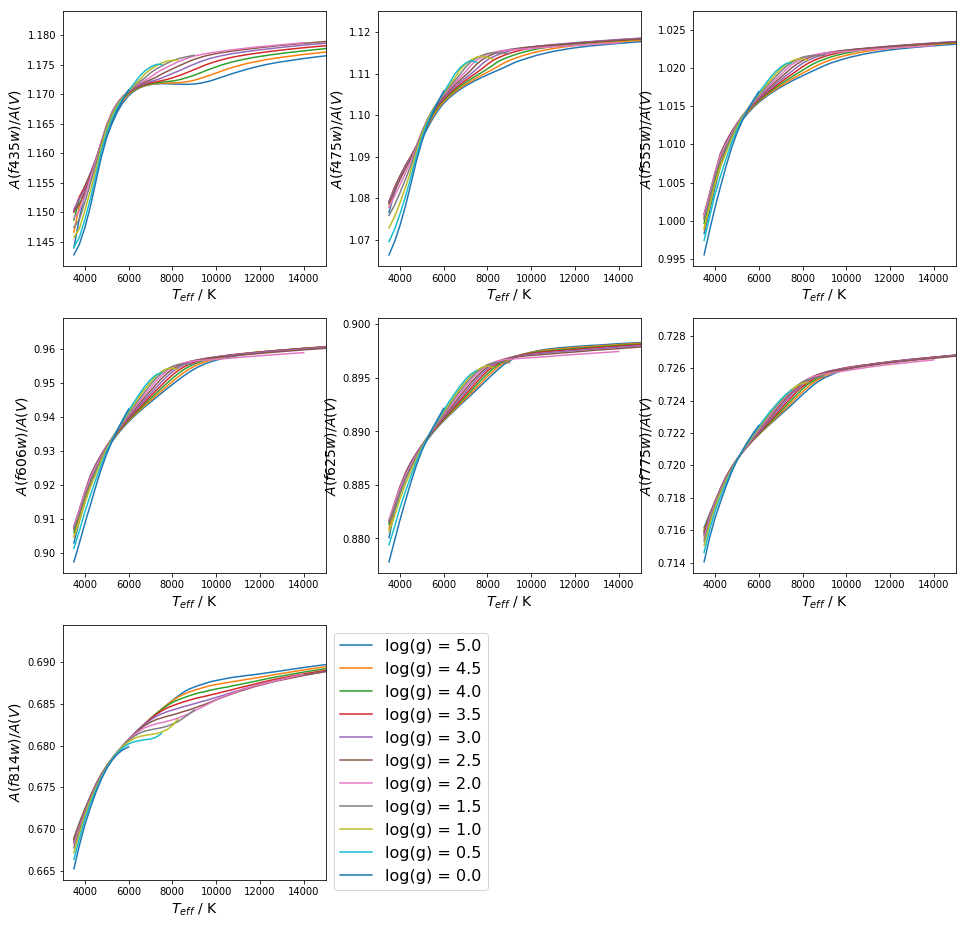

3.1,-2.0


Deleting missing subplots - discrepancy between 7 and 9


3.1,-1.0


Deleting missing subplots - discrepancy between 7 and 9


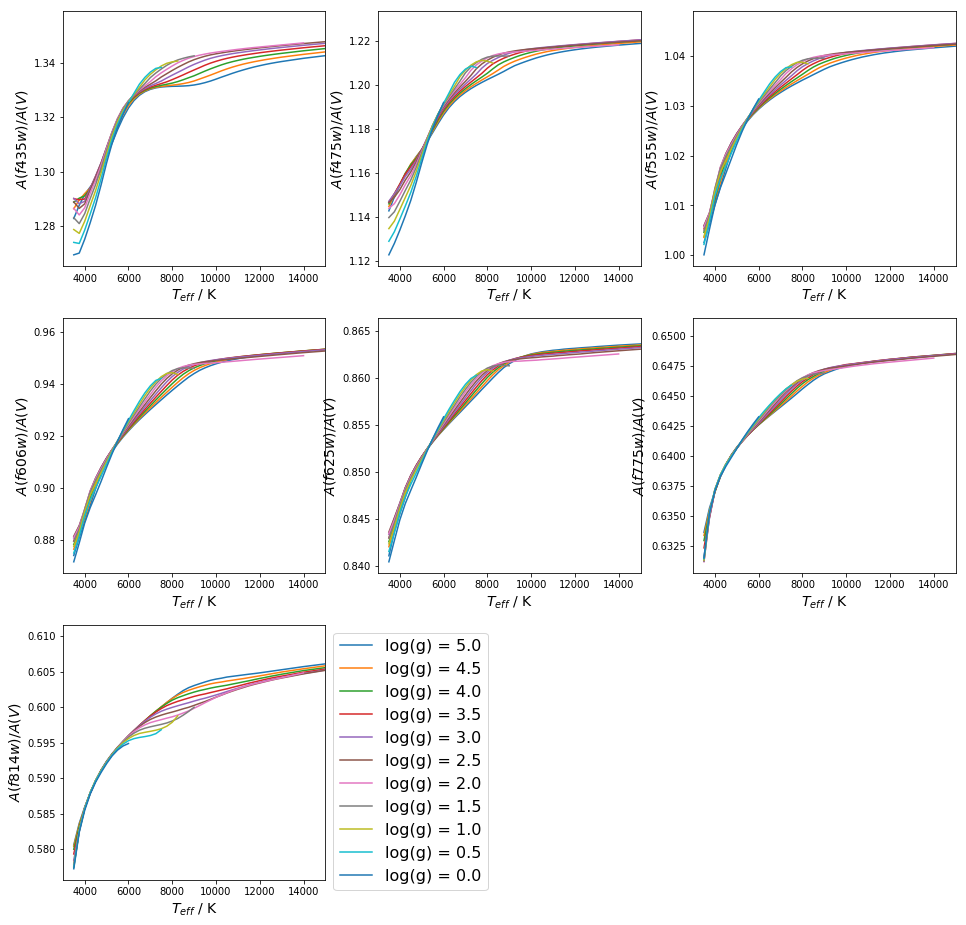

6.0,-1.0


Deleting missing subplots - discrepancy between 7 and 9


6.0,0.0


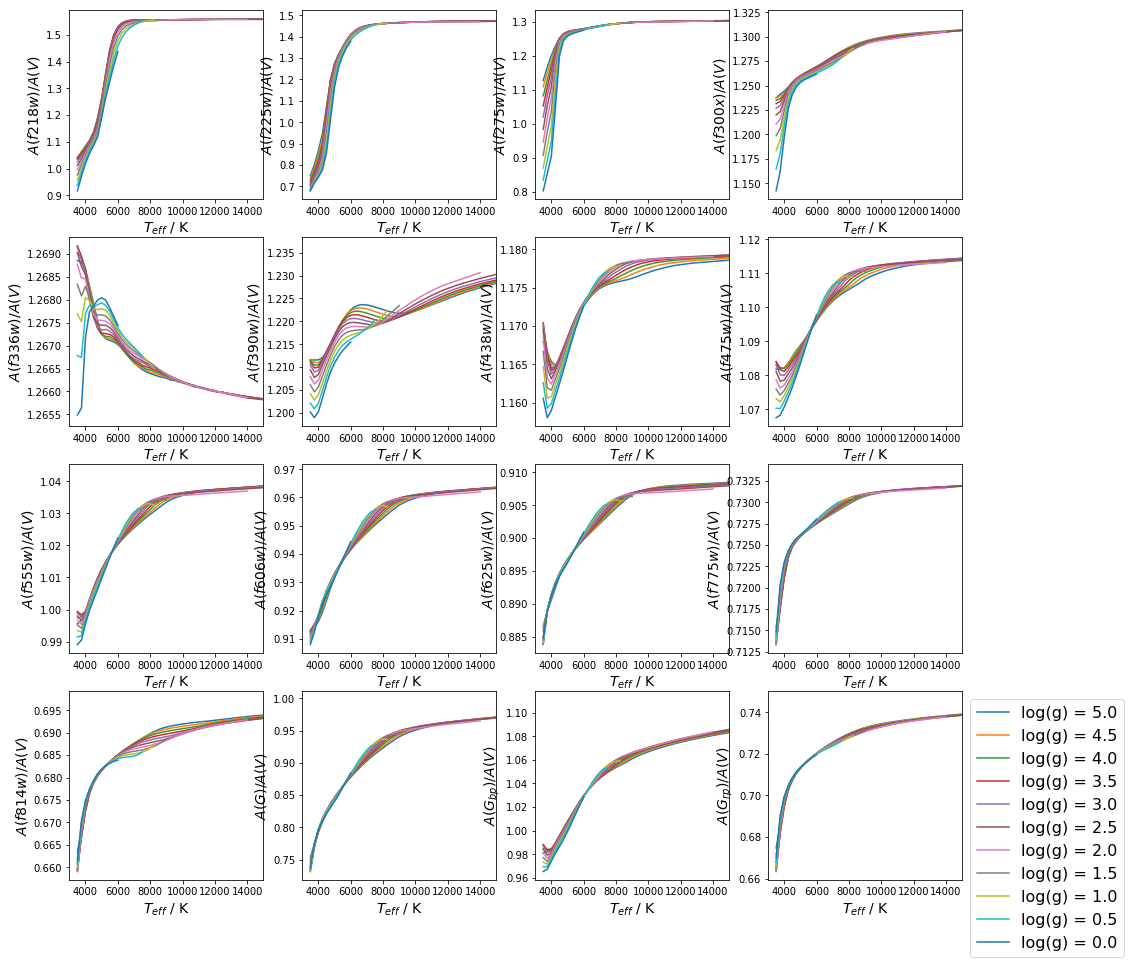

Deleting missing subplots - discrepancy between 7 and 9


2.0,-1.0


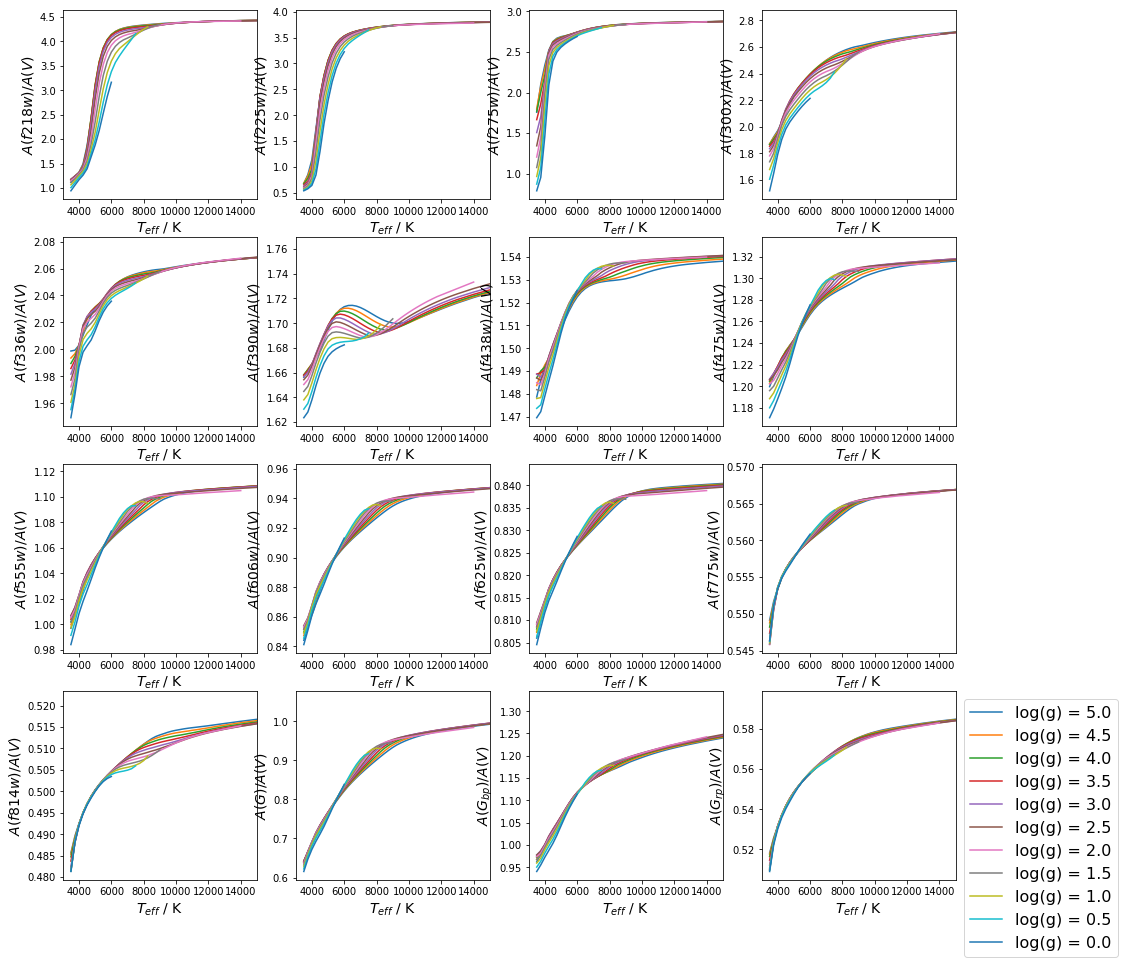

Deleting missing subplots - discrepancy between 7 and 9


3.1,0.5


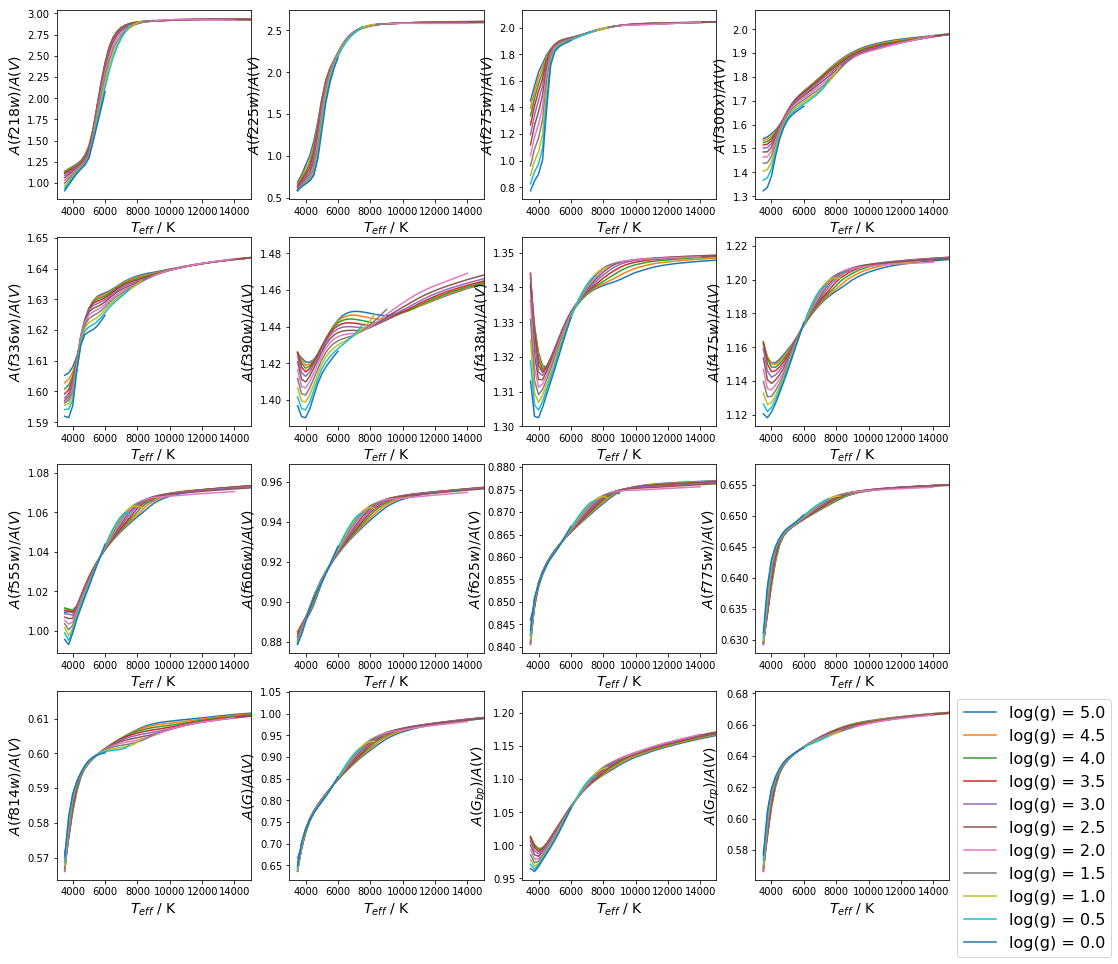

Deleting missing subplots - discrepancy between 7 and 9


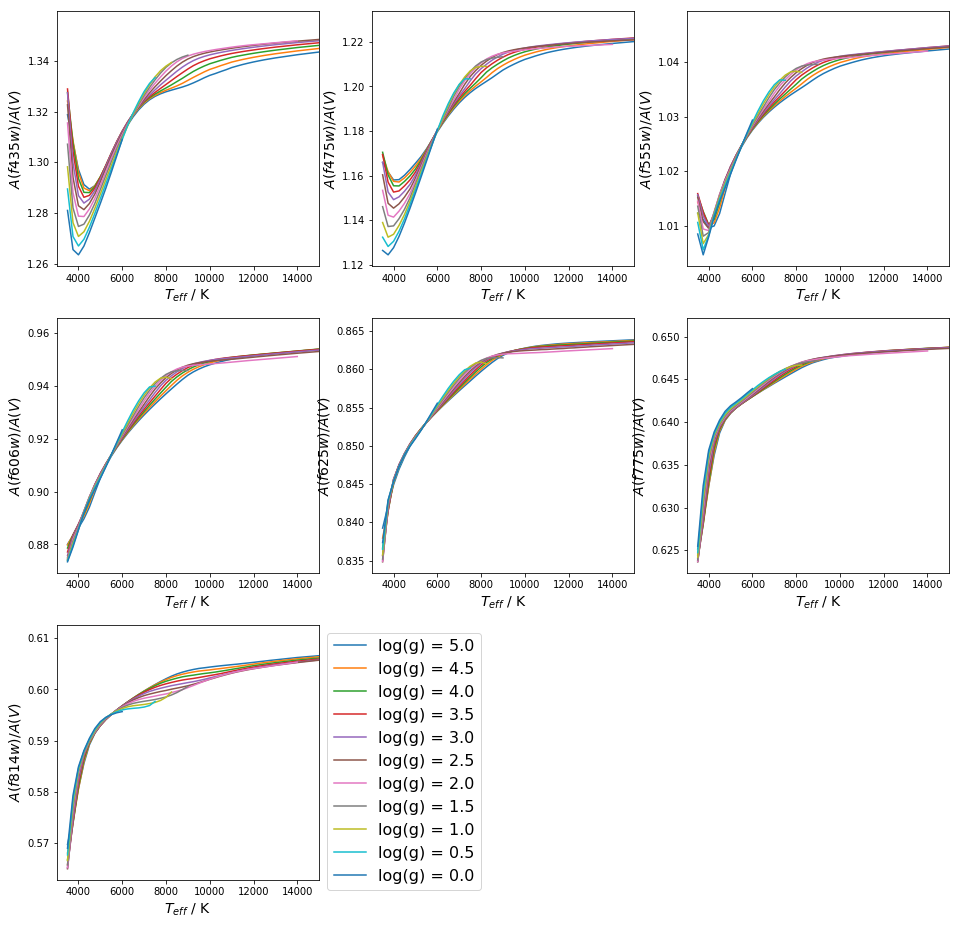

6.0,0.5


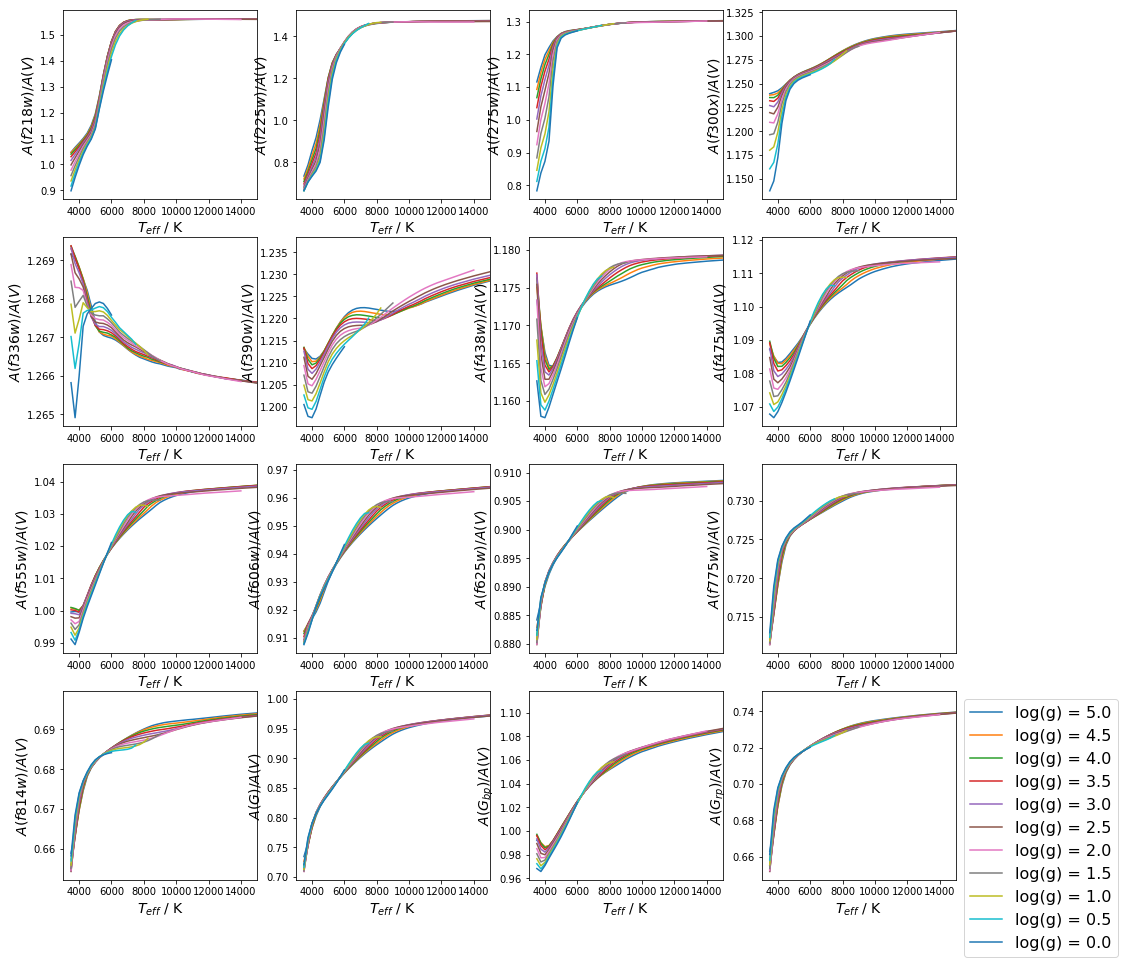

Deleting missing subplots - discrepancy between 7 and 9


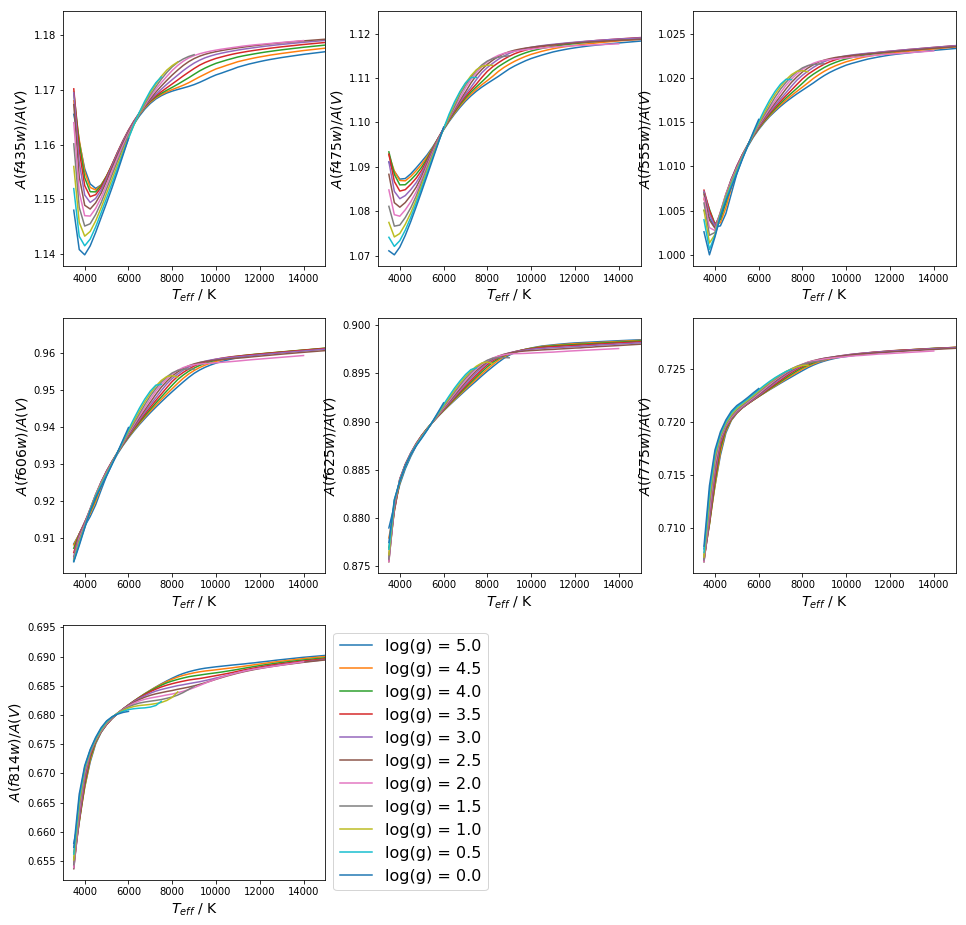

2.0,0.0


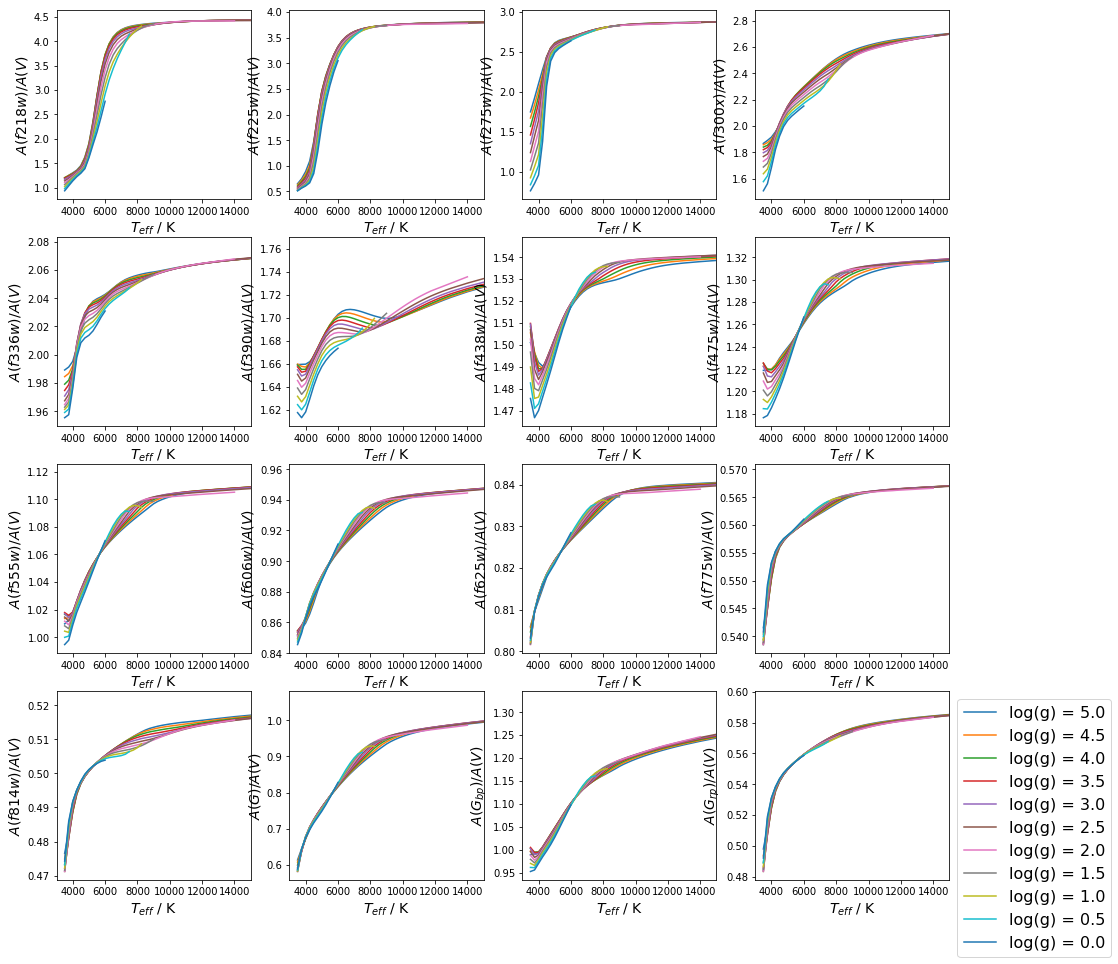

Deleting missing subplots - discrepancy between 7 and 9


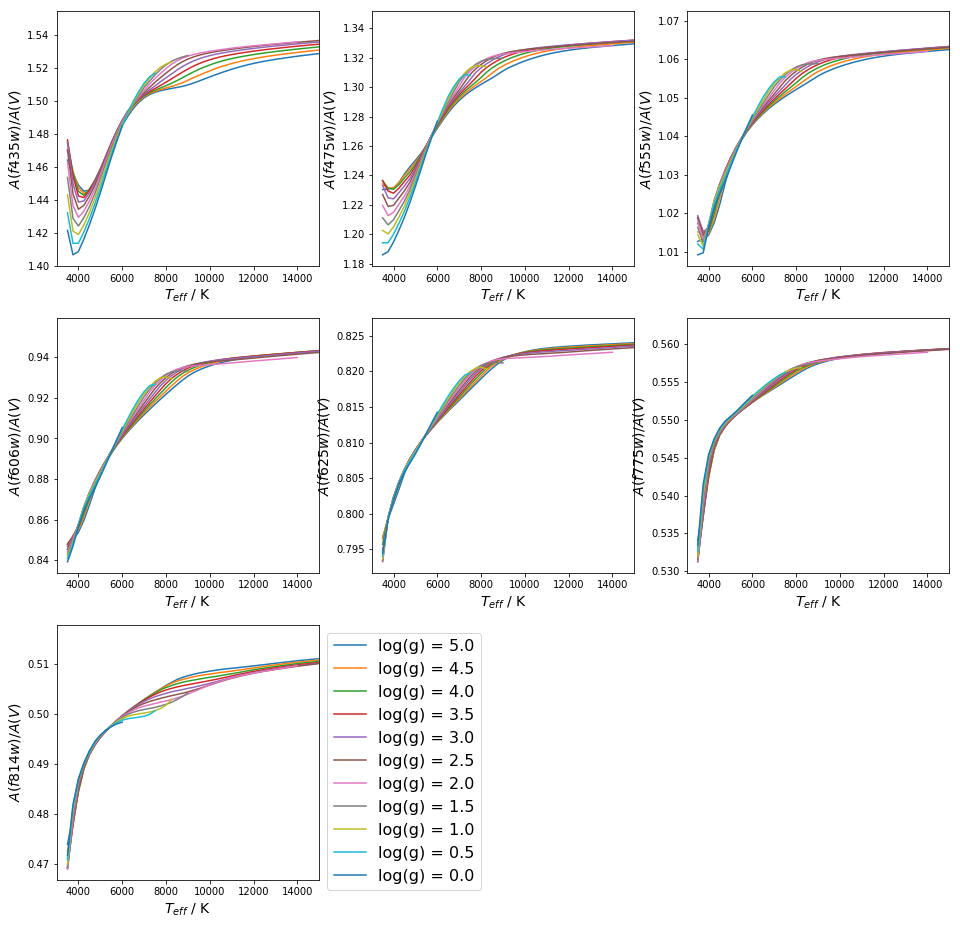

2.0,-2.0


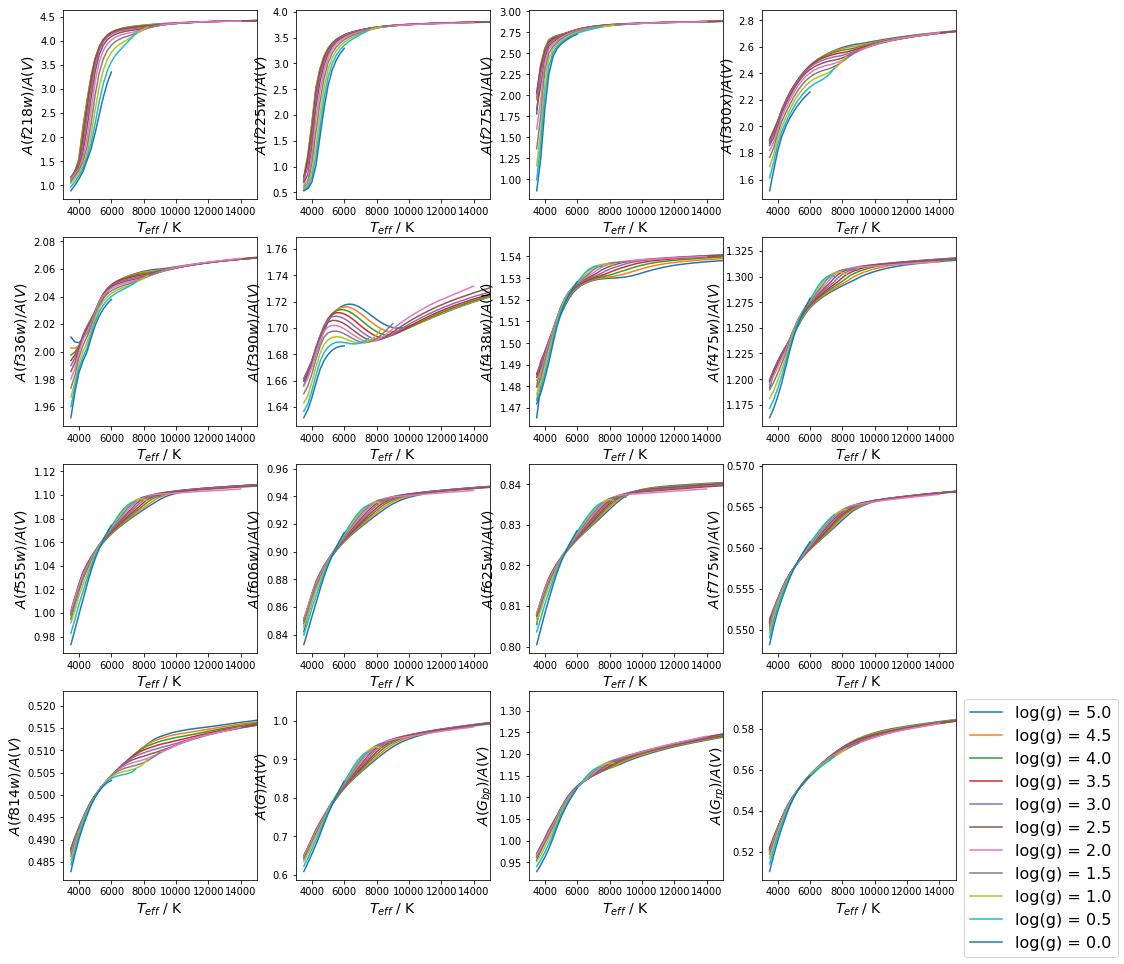

Deleting missing subplots - discrepancy between 7 and 9


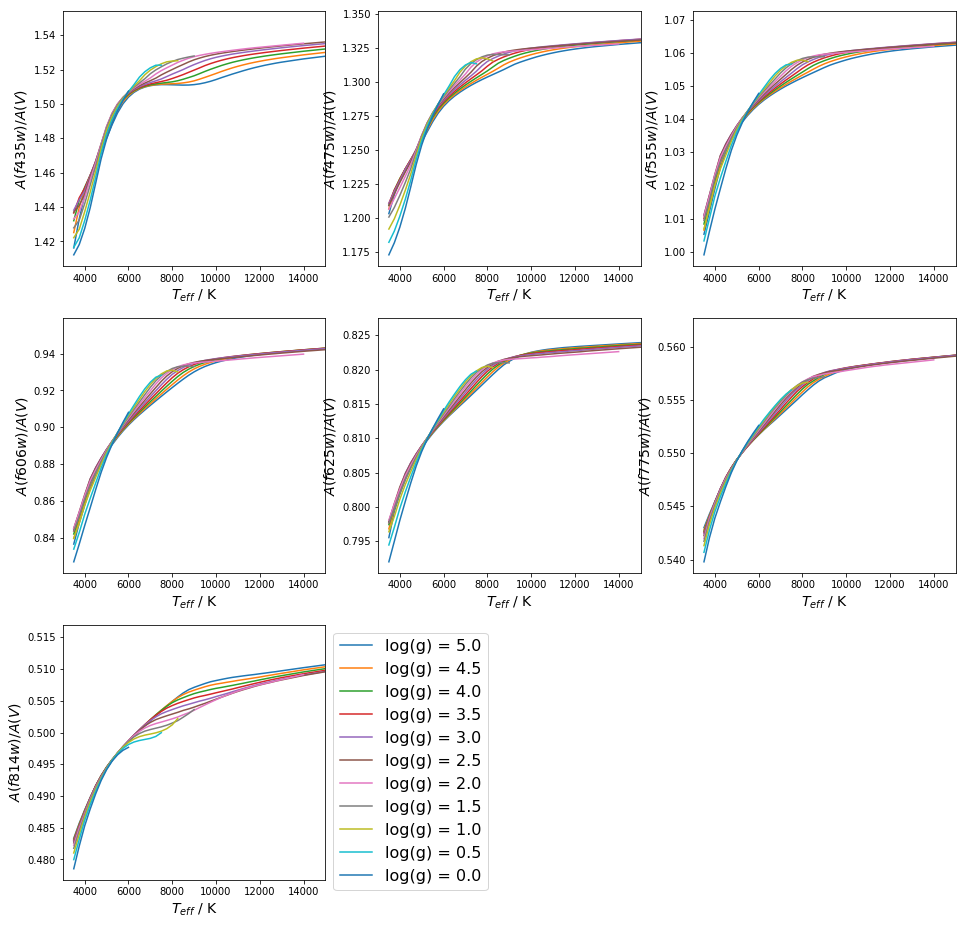

2.0,0.5


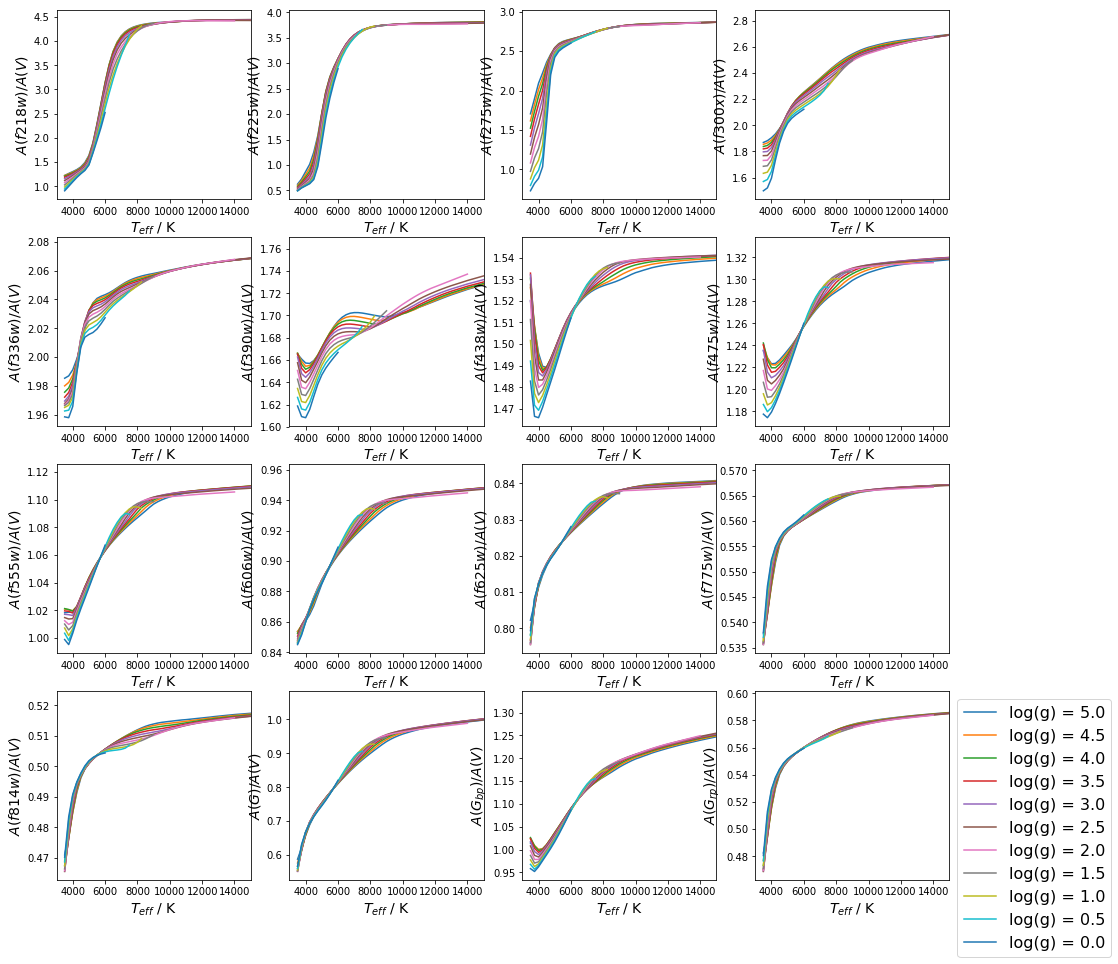

Deleting missing subplots - discrepancy between 7 and 9


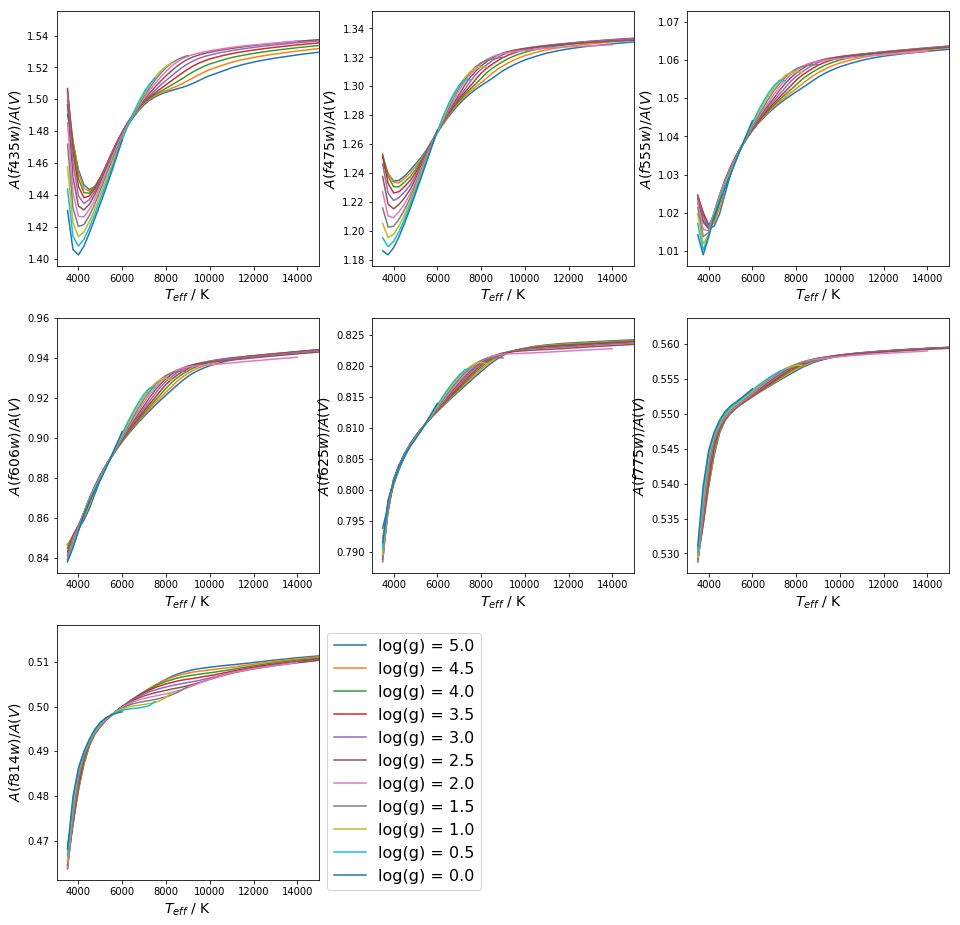

3.1,0.0


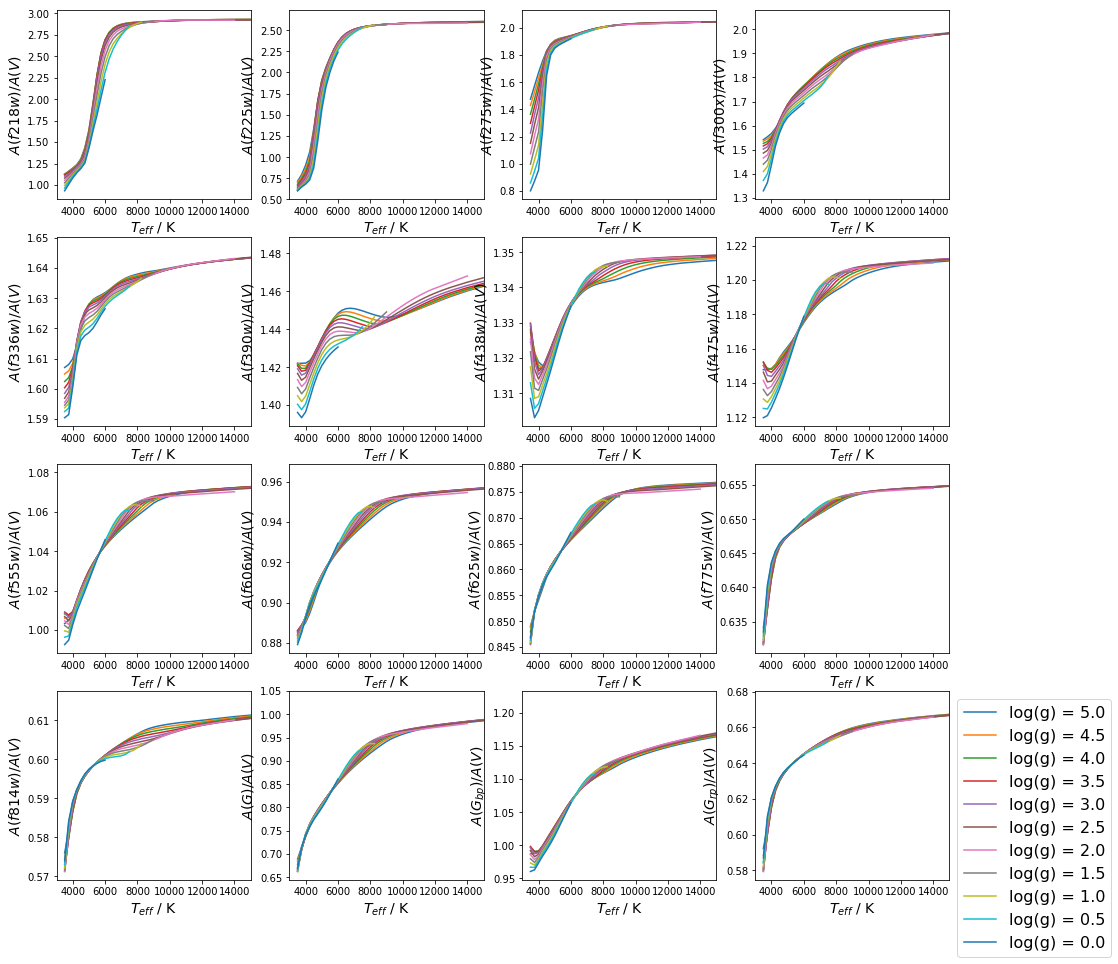

Deleting missing subplots - discrepancy between 7 and 9


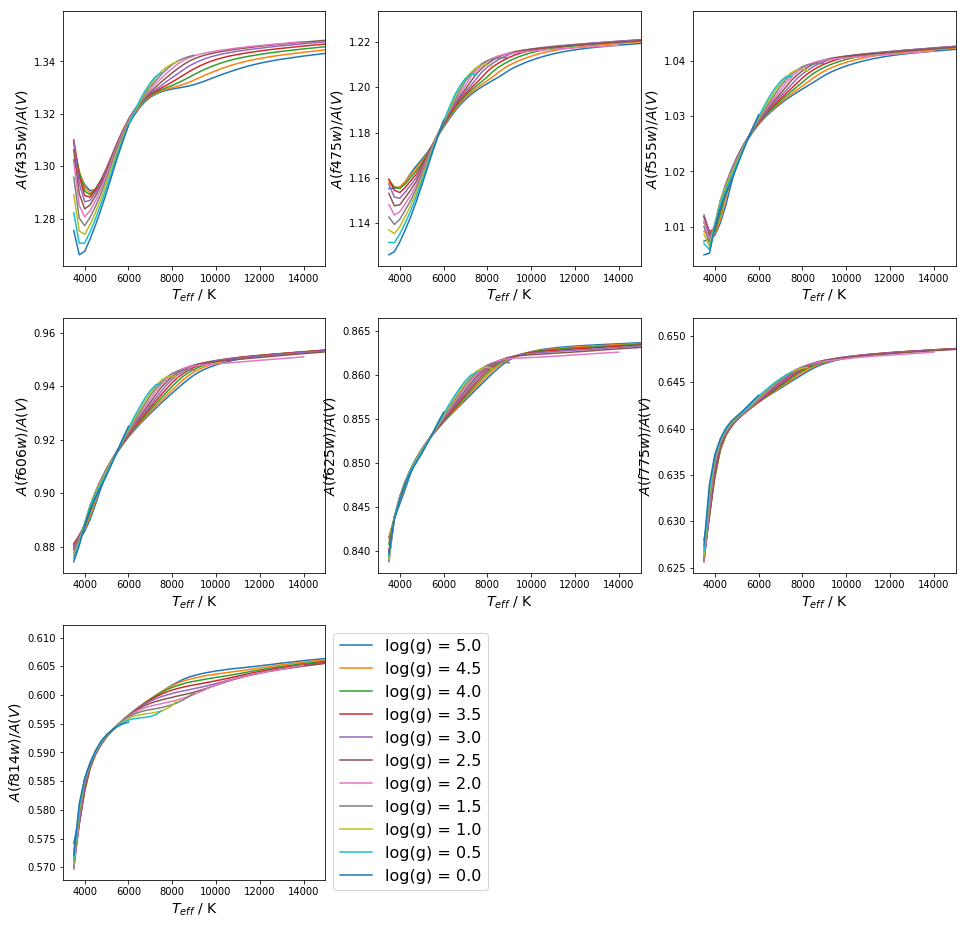

In [33]:
# APRIL 2019: for thesis, just need data: no fits!
# Change font sizes to makes figure legends and axes labels bigger
# NOTE: 10 pt is the default standard font size
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16)    # legend fontsize


def just_fortran_data_plot(input_dict,Rv_metal_key,var_names_comb,folder,graph_fold='',extras='',save_stuff='y',zoom_min=None,zoom_max=None):
    data_dict = input_dict[Rv_metal_key]
    find_Rv = re.search('(.*),',Rv_metal_key)
    if find_Rv:
        Rv = str(find_Rv.group(1))
    find_metal = re.search(',(.*)',Rv_metal_key)
    if find_metal:
        metal = str(find_metal.group(1))
    Rv = Rv.replace('.','p')
    metal = metal.replace('.','p')
    if ('-' in metal):
        metal = metal.replace('-','m')
    if ( (zoom_min is not None) and (zoom_max is not None)):
        plot_dir_str_metal = folder + '/' + graph_fold + '/Ax_Av_Rv'+Rv+'_FeH' + metal + '_just_Teff_plot_' + str(zoom_min) + '_' + str(zoom_max) + extras + '.pdf'
    else:
        plot_dir_str_metal = folder + '/' + graph_fold + '/Ax_Av_Rv'+Rv+'_FeH' + metal + '_just_Teff_plot' + extras + '.pdf'
    if (len(data_dict['5.0'][0,:]) > 11):
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        Nrows = 4
        Ncols = 4
    else:
        fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(16, 16))
        Nrows = 3
        Ncols = 3
    axs = axs.ravel()
    # Write out to new file: first 'with' statement empties the file to be written into later
    # Iteration for changes BETWEEN filters !!!
    for i in range(2,len(data_dict['5.0'][0,:])):
        axs[i-2].set_xlabel(var_names_comb[0])
        axs[i-2].set_ylabel(var_names_comb[i])
        for keyval in reversed(sorted(data_dict.iterkeys())):
            A_X_chosen = data_dict[keyval]
            axs[i-2].plot(A_X_chosen[:,0],A_X_chosen[:,i],marker='',linestyle='-',label='log(g) = '+keyval)#,marker='x',linestyle='--'
            if ( (zoom_min is not None) and (zoom_max is not None)):
                axs[i-2].set_xlim(zoom_min,zoom_max)
    if ( (len(data_dict['5.0'][0,:]) - 2) < (Nrows*Ncols) ):
        print 'Deleting missing subplots - discrepancy between ' + str(len(data_dict['5.0'][0,:]) - 2) + ' and ' + str(Nrows*Ncols)
        for d in range((len(data_dict['5.0'][0,:]) - 2),(Nrows*Ncols)):
            fig.delaxes(axs[d])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
    fig.tight_layout()
    if (save_stuff == 'y'):
        fig.savefig(plot_dir_str_metal, bbox_inches='tight')

folder_str = 'Rv_varied'
for Rz_key in comb_Ax_Av_dict:
    print Rz_key
    just_fortran_data_plot(comb_Ax_Av_dict,Rz_key,var_names_comb,folder_str+'/just_full_data',graph_fold='/comb',extras='_comb_lines',zoom_min=3000,zoom_max=15000)
    just_fortran_data_plot(ACS_Ax_Av_dict,Rz_key,var_names_ACS,folder_str+'/just_full_data',graph_fold='/ACS',extras='_ACS_lines',zoom_min=3000,zoom_max=15000)
    #,save_stuff='n'